In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
import ghibtools as gh
from params import *
import mne
import seaborn as sns

**Deux choses :**
- Trouver la modulante des fuseaux dans le signal cérébral
- Voir si cette modulante est modulée par la respi

**Pour trouver la modulante des fuseaux :**
- Récupérer la phase de différentes bandes de fréquence
- Compter le timing des fuseaux par rapport à ces phases

**Pour voir si cette modulante est modulée par la respi :**
- PAC de la respi sur les oscillations cérébrales
- Voir ce qui se passe par rapport à la possible modulante des fuseaux ?

In [3]:
def get_da_phase(da, stage, f_start = 0., f_stop = 6, step = 0.1):
    chan_sig = da.loc[stage,'Fp2-C4',:].values
    da_precompute = None
    filter_width = 0.4

    freqs = np.arange(f_start * 10, f_stop*10, filter_width * 10) / 10
    for fi in freqs:
        fi = round(fi, 1)
        # print(fi)
        if fi - filter_width <= 0:
            low = None
        else:
            low = fi - filter_width
        high = fi + filter_width
        # print(low , high)
        fi_filtered = gh.filter_sig(chan_sig, fs=srate, low = low, high = high)
        fi_phase = gh.get_phase(fi_filtered)
        if da_precompute is None:
            da_precompute = gh.init_da({'feature':['phase','filtered'],'freq':freqs,'time':da.coords['time'].values})
        da_precompute.loc['phase',fi,:] = fi_phase
        da_precompute.loc['filtered',fi,:] = fi_filtered
    return da_precompute

In [4]:
def load_spindles(patient , stage_to_study):
    spindle_file = f'../df_analyse/spindles_{patient}.xlsx'
    spindles = pd.read_excel(spindle_file).drop(columns = 'Unnamed: 0')
    spindles = spindles[spindles['stage'] == stage_to_study]
    return spindles

In [5]:
def count_spindles_by_phase_bin(nbins, patient, spindles, df_cycles, cycle_spindled, show=False):
    spindles_times = spindles['Peak']
    
    count = []

    for cycle in cycle_spindled:
        
        start = df_cycles.loc[cycle,'start time']
        stop = df_cycles.loc[cycle,'stop time']

        phases_timings = np.linspace(start, stop, nbins + 1)
        
        spindles_of_the_cycle = spindles_times[(spindles_times >= start) & (spindles_times <= stop)].values
        
        for spindle_time in spindles_of_the_cycle:
            for i, phase_start in enumerate(phases_timings):
                if phase_start != phases_timings[-1]:
                    phase_stop = phases_timings[i + 1]
                    if spindle_time >= phase_start and spindle_time < phase_stop:
                        count.append(i)
                        
    phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
    phase_count = phase_count.to_frame().T
    phase_count.insert(0 , 'norm' , 'no')
    phase_count_norm = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))
    phase_count_norm = phase_count_norm.to_frame().T
    phase_count_norm.insert(0 , 'norm' , 'yes')
    
    df_concat = pd.concat([phase_count, phase_count_norm], axis = 0)
    
    df_concat.insert(0 , 'patient', patient)

    return df_concat

In [6]:
def get_cycles_from_phase(phase):
    gradient = -1
    cycles = np.where(np.gradient(phase) < gradient)[0][::2]
    
    c = []
    for i in range(0, cycles.size):
        if i == cycles.size -1:
            break
        start_idx = cycles[i]
        stop_idx =  cycles[i+1]
        start_time = start_idx / srate
        stop_time = stop_idx / srate
        duration = stop_time - start_time
        c.append([start_idx ,stop_idx, start_time, stop_time , duration])
    df_features_of_fi = pd.DataFrame(c, columns = ['start idx','stop idx', 'start time', 'stop time', 'duration'])
    return df_features_of_fi

In [7]:
def which_cycle_find_spindle(spindles, df_cycles):
    spindles_times = spindles['Peak'].values

    count = []

    for cycle in range(df_cycles.shape[0]):

        start = df_cycles.loc[cycle,'start time']
        stop = df_cycles.loc[cycle,'stop time']
        
        for spindle_time in spindles_times:
            if spindle_time >= start and spindle_time < stop:
                count.append(cycle)
    cycles_with_spindle = pd.Series(count).unique()

    return cycles_with_spindle

In [8]:
def mi_from_fi(fi, da, spindles, show = False):
    df_features_of_fi = get_cycles_from_phase(phase=da.loc['phase',fi,:])
    cycles_with_spindle = which_cycle_find_spindle(spindles, df_features_of_fi)
    count_by_bin_18 = count_spindles_by_phase_bin(nbins=18, patient=patient, spindles=spindles, df_cycles=df_features_of_fi, cycle_spindled=cycles_with_spindle)
    values_18 = count_by_bin_18[count_by_bin_18['norm'] == 'yes'].drop(columns=['patient','norm']).values[0]
    mi = gh.Modulation_Index(values_18, show = show)
    return mi

In [219]:
def get_fi_mi_from_patient(patient, start=0.2, stop = 2, step = 0.1):
    stage = 'N2'
    da_data = xr.load_dataarray(f'../dataarray/da_staged_{patient}.nc')
    da_precompute = get_da_phase(da_data, stage, f_start = start, f_stop = stop, step = step)
    spindles = load_spindles(patient , stage)

    rows = []
    for fi in da_precompute.coords['freq'].values:
        print(fi)
        mi = mi_from_fi(fi=fi, da=da_precompute, spindles=spindles)
        rows.append([patient, fi, mi])
    df_fi_mi = pd.DataFrame(rows, columns = ['patient','freq', 'mi'])
    
    return df_fi_mi

In [220]:
concat = []
for patient in patients:
    df_patient = get_fi_mi_from_patient(patient)
    concat.append(df_patient)
df_all = pd.concat(concat)

0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
0.2
0.3
0.4


/tmp/ipykernel_2975645/47218992.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cycles_with_spindle = pd.Series(count).unique()
/tmp/ipykernel_2975645/858950885.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
/tmp/ipykernel_2975645/858950885.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count_norm = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))
/tmp/ipykernel_2975645/47218992.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a 

0.5
0.6
0.7


/tmp/ipykernel_2975645/47218992.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cycles_with_spindle = pd.Series(count).unique()
/tmp/ipykernel_2975645/858950885.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
/tmp/ipykernel_2975645/858950885.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count_norm = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))
/tmp/ipykernel_2975645/47218992.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a 

0.8
0.9
1.0


/tmp/ipykernel_2975645/47218992.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cycles_with_spindle = pd.Series(count).unique()
/tmp/ipykernel_2975645/858950885.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
/tmp/ipykernel_2975645/858950885.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count_norm = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))
/tmp/ipykernel_2975645/47218992.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a 

1.1
1.2
1.3


/tmp/ipykernel_2975645/47218992.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cycles_with_spindle = pd.Series(count).unique()
/tmp/ipykernel_2975645/858950885.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
/tmp/ipykernel_2975645/858950885.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count_norm = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))
/tmp/ipykernel_2975645/47218992.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a 

1.4
1.5
1.6


/tmp/ipykernel_2975645/47218992.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cycles_with_spindle = pd.Series(count).unique()
/tmp/ipykernel_2975645/858950885.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
/tmp/ipykernel_2975645/858950885.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count_norm = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))
/tmp/ipykernel_2975645/47218992.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a 

1.7
1.8
1.9


/tmp/ipykernel_2975645/47218992.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cycles_with_spindle = pd.Series(count).unique()
/tmp/ipykernel_2975645/858950885.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
/tmp/ipykernel_2975645/858950885.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count_norm = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))
/tmp/ipykernel_2975645/47218992.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a 

0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9


In [221]:
# df_all.to_excel('../df_analyse/fi_mi_all.xlsx')

In [222]:
# df_all = pd.read_excel('../df_analyse/fi_mi_all.xlsx', index_col = 0)

In [226]:
df_all

,patient,freq,mi
0,P1,0.2,0.004346
1,P1,0.3,0.006412
2,P1,0.4,0.003777
3,P1,0.5,0.001352
4,P1,0.6,0.001475
...,...,...,...
13,P10,1.5,0.002364
14,P10,1.6,0.002986
15,P10,1.7,0.003513
16,P10,1.8,0.004390


<AxesSubplot:xlabel='freq', ylabel='mi'>

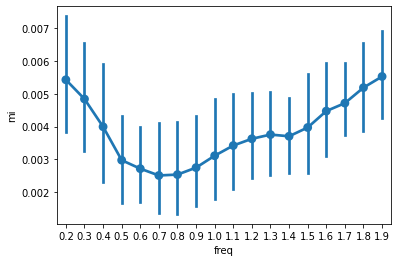

In [227]:
sns.pointplot(data=df_all , x='freq', y = 'mi')

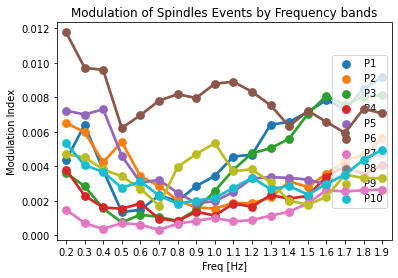

In [232]:
fig, ax = plt.subplots()
sns.pointplot(data=df_all , x='freq', y = 'mi', hue = 'patient',ax=ax)
ax.set_title('Modulation of Spindles Events by Frequency bands')
ax.legend(loc = 'right')
ax.set_ylabel('Modulation Index')
ax.set_xlabel('Freq [Hz]')
# plt.savefig('../presentation_4/modulogram_spindles', bbox_inches = 'tight')
plt.show()

<AxesSubplot:xlabel='freq', ylabel='mi'>

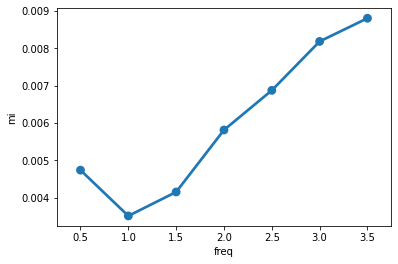

In [54]:
sns.pointplot(data=df_all.groupby('freq').mean().reset_index() , x='freq', y = 'mi')

In [44]:
concat = []
for patient in patients:
    concat.append(df_all[(df_all['patient'] == patient) & (df_all['freq'] <= 6)].sort_values(by = 'mi', ascending = False).iloc[0,:])
best_modulant_by_patient = pd.concat(concat, axis = 1).T

In [45]:
best_modulant_by_patient

,patient,freq,mi
8,P1,3.4,0.015542
0,P2,0.2,0.012177
14,P3,5.8,0.012715
12,P4,5.0,0.006547
14,P5,5.8,0.019293
12,P6,5.0,0.014387
13,P7,5.4,0.007463
0,P8,0.2,NaN
0,P9,0.2,0.008997
0,P10,0.2,0.014602


In [20]:
best_modulant_by_patient.mean()

/tmp/ipykernel_2975645/1044040181.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  best_modulant_by_patient.mean()


freq    3.120000
mi      0.012414
dtype: float64

**Pour voir si cette modulante est modulée par la respi :**
- PAC de la respi sur les oscillations cérébrales
- Voir ce qui se passe par rapport à la possible modulante des fuseaux ?

In [21]:
da_data = xr.load_dataarray(f'../dataarray/da_staged_{patient}.nc').sel(stage = 'N2', chan = ['Fp2-C4','DEBIT'])

In [22]:
da_data

<xarray.DataArray (chan: 2, time: 2342400)>
array([[ 95.14649446,  95.97592585,  94.95048881, ..., 217.71074974,
        217.34368052, 216.66289558],
       [ 27.58601872,  27.91584779,  28.28031039, ...,  29.64699907,
         29.71136266,  29.61590715]])
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 9.15e+03 9.15e+03 9.15e+03
  * chan     (chan) object 'Fp2-C4' 'DEBIT'
    stage    <U2 'N2'

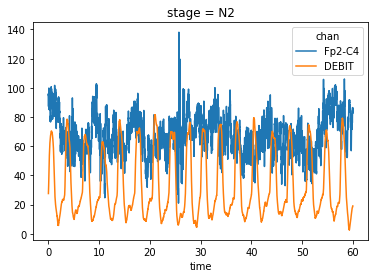

In [23]:
da_data.loc[:,0:60].plot.line(x='time', hue = 'chan')

In [24]:
filtered_resp = gh.filter_sig(da_data.loc['DEBIT',:].values, fs=srate, low = 0.1, high = 0.7)
phase_resp = gh.get_phase(filtered_resp)

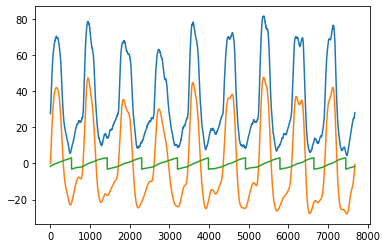

In [25]:
plt.plot(da_data.loc['DEBIT',:].values[0:srate*30])
plt.plot(filtered_resp[0:srate*30])
plt.plot(phase_resp[0:srate*30])

In [26]:
eeg_sig = da_data.loc['Fp2-C4',:].values
eeg_filtered = gh.filter_sig(eeg_sig, fs=srate, low = 3.5, high = 4.5)
envelope_eeg_filtered = gh.get_amp(eeg_filtered)

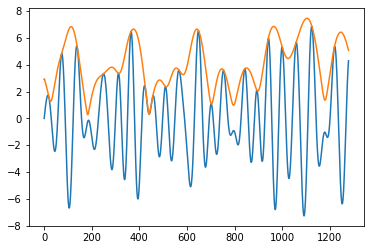

In [27]:
plt.plot(eeg_filtered[0:5*srate])
plt.plot(envelope_eeg_filtered[0:5*srate])

In [28]:
f, Pxx = signal.welch(envelope_eeg_filtered, fs = srate, nperseg = int(srate * 100))

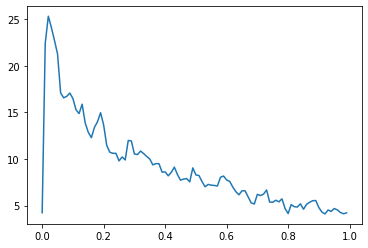

In [29]:
plt.plot(f[0:100], Pxx[0:100])

In [30]:
pac_distribution = gh.get_amplitude_distribution(phase_resp, envelope_eeg_filtered)

0.00010554455132515269

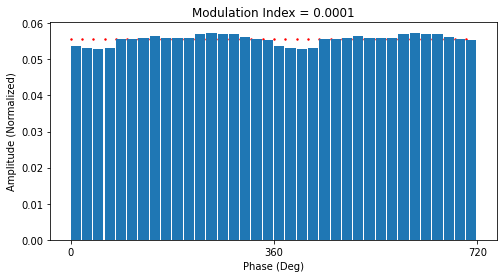

In [31]:
gh.Modulation_Index(pac_distribution, show = True)

In [32]:
def get_mi_fi_resp(phase_resp, eeg_sig, fi, half_width = 1, show = False):
    low = fi - half_width
    high = fi + half_width
    
    if low <= 0:
        low = None
    
    eeg_filtered = gh.filter_sig(eeg_sig, fs=srate, low = low, high = high)
    envelope_eeg_filtered = gh.get_amp(eeg_filtered)
    pac_distribution = gh.get_amplitude_distribution(phase_resp, envelope_eeg_filtered)
    mi = gh.Modulation_Index(pac_distribution, show = show)
    # return mi
    return mi, eeg_filtered, envelope_eeg_filtered

In [33]:
rows = []
da_features = None
freqs = np.arange(1,100,1)
for fi in freqs:
    if fi in np.arange(0,100,10):
        print(fi)
    for half_width in [0.1,0.5,1,2]:
        mi, eeg_filtered, envelope_eeg_filtered = get_mi_fi_resp(phase_resp, eeg_sig, fi=fi, half_width=half_width,  show =False)
        if da_features is None:
            da_features = gh.init_da({'features':['filtered','envelope'], 'width':[0.1,0.5,1,2], 'freq':freqs, 'time':gh.time_vector(eeg_filtered, srate)})
        da_features.loc['filtered',half_width,fi,:] = eeg_filtered
        da_features.loc['envelope',half_width,fi,:] = envelope_eeg_filtered
        rows.append([half_width, fi, mi])
df_mi_resp = pd.DataFrame(rows, columns = ['width','freq','mi'])

10
20
30
40
50
60
70
80
90


In [34]:
da_features = da_features.astype('float32')

In [35]:
da_features

<xarray.DataArray (features: 2, width: 4, freq: 99, time: 2342400)>
array([[[[-7.77156117e-15, -4.77694115e-03, -9.96959768e-03, ...,
          -1.08769774e-01, -5.45227081e-02, -1.50990331e-14],
         [-3.01980663e-14,  6.91520870e-02,  1.38582811e-01, ...,
          -1.14343655e+00, -5.73143303e-01, -6.26165786e-14],
         [-1.33226763e-14,  1.24882750e-01,  2.48987108e-01, ...,
          -1.68656635e+00, -8.45180452e-01, -3.21964677e-14],
         ...,
         [-3.23074900e-14, -1.74787402e-01,  2.77636915e-01, ...,
           3.23083878e-01, -2.30970785e-01, -5.87307980e-14],
         [ 3.33066907e-15, -1.84596404e-01,  2.79619038e-01, ...,
           3.23928505e-01, -2.32437506e-01,  1.89848137e-14],
         [-1.25455202e-14, -1.88307196e-01,  2.75279284e-01, ...,
           3.22360665e-01, -2.31664985e-01, -1.37667655e-14]],

        [[ 7.99360578e-15,  2.65681036e-02,  5.29901460e-02, ...,
          -3.66815388e-01, -1.83825895e-01, -5.99520433e-15],
         [-1.31006317e-14,  1.87930390e-02,  3.73393185e-02, ...,
          -1.56152987e+00, -7.82674849e-01, -3.93018951e-14],
         [ 2.56461519e-14,  2.93707728e-01,  5.84517777e-01, ...,
          -1.46263146e+00, -7.32378662e-01,  6.68354261e-14],
...
           3.33278805e-01,  3.27510238e-01,  2.07756847e-01],
         [ 1.77477092e-01,  2.67694771e-01,  2.71021813e-01, ...,
           3.36656988e-01,  3.33245248e-01,  2.09336042e-01],
         [ 1.76932290e-01,  2.66571313e-01,  2.68068373e-01, ...,
           3.37485850e-01,  3.35357249e-01,  2.08632648e-01]],

        [[ 5.91585205e+02,  5.15917725e+02,  5.16488098e+02, ...,
           5.47839905e+02,  5.48602539e+02,  6.21773621e+02],
         [ 5.91877197e+02,  5.15910461e+02,  5.16318420e+02, ...,
           5.49533386e+02,  5.49989624e+02,  6.22610901e+02],
         [ 2.57518768e+00,  2.42007518e+00,  2.21929622e+00, ...,
           3.61211586e+00,  3.36280251e+00,  2.93713331e+00],
         ...,
         [ 1.68391749e-01,  2.53568023e-01,  2.64270753e-01, ...,
           3.48110855e-01,  3.38707447e-01,  2.11222768e-01],
         [ 1.66263670e-01,  2.47774497e-01,  2.56030709e-01, ...,
           3.45574647e-01,  3.37084860e-01,  2.11240783e-01],
         [ 1.64683446e-01,  2.45946154e-01,  2.51838863e-01, ...,
           3.50108117e-01,  3.42108130e-01,  2.09729359e-01]]]],
      dtype=float32)
Coordinates:
  * features  (features) <U8 'filtered' 'envelope'
  * width     (width) float64 0.1 0.5 1.0 2.0
  * freq      (freq) int64 1 2 3 4 5 6 7 8 9 10 ... 91 92 93 94 95 96 97 98 99
  * time      (time) float64 0.0 0.003906 0.007812 ... 9.15e+03 9.15e+03

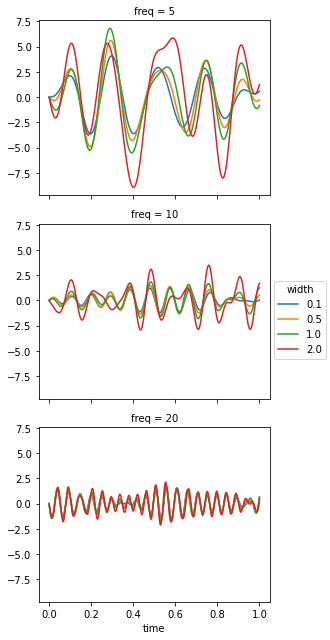

In [36]:
da_features.loc['filtered',:,[5,10,20],0:1].plot.line(x='time', hue = 'width', row = 'freq')

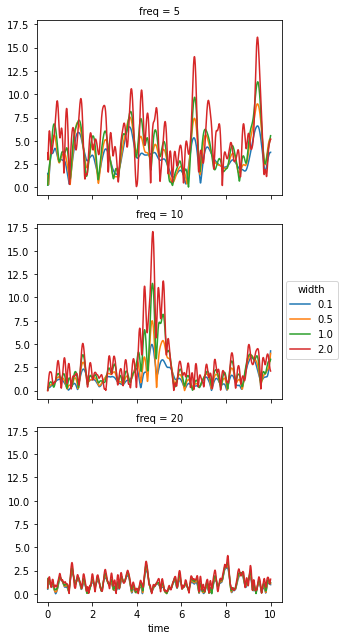

In [37]:
da_features.loc['envelope',:,[5,10,20],0:10].plot.line(x='time', hue = 'width', row = 'freq')

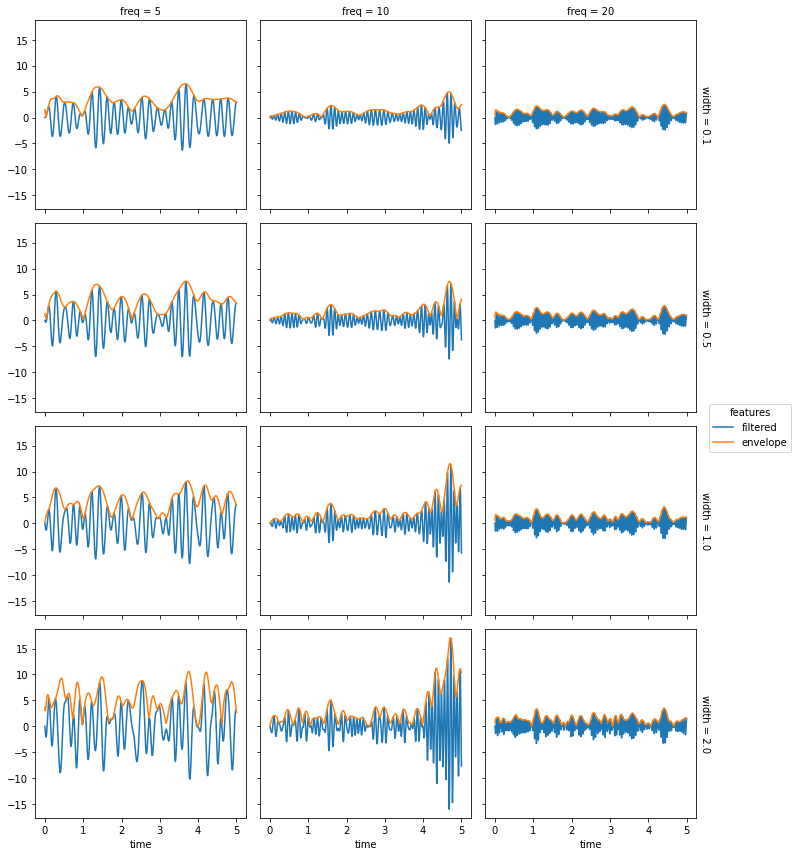

In [38]:
da_features.loc[:,:,[5,10,20],0:5].plot.line(x='time', hue = 'features', col = 'freq', row = 'width')

In [39]:
sns.lineplot(data=df_sel_bande, x='freq' , y = 'mi')

NameError: name 'df_sel_bande' is not defined

In [ ]:
df_sel_bande = df_mi_resp[df_mi_resp['width'] == 0.5]

In [ ]:
get_mi_fi_resp(phase_resp, eeg_sig, fi=80,  show =True)

In [ ]:
da_features.loc['filtered',[5,15,25,35,65,85,95],0:10].plot.line(x='time')

In [ ]:
del da_features

In [ ]:
da_features

In [235]:
eeg_sig = da_data.loc['Fp2-C4',:].mean('chan').values

ValueError: 'chan' not found in array dimensions ('time',)

In [ ]:
eeg_sig_filtered = gh.filter_sig(eeg_sig , fs =srate , low = 1.8 , high =4)

In [ ]:
eeg_sig_filtered_phase = gh.get_phase(eeg_sig_filtered)

In [ ]:
plt.plot(eeg_sig[0:2*srate])
plt.plot(eeg_sig_filtered[0:2*srate])

In [ ]:
plt.figure(figsize = (20,15))
plt.plot(eeg_sig_filtered[0:10*srate])
plt.plot(eeg_sig_filtered_phase[0:10*srate])

In [ ]:
fig, axs = plt.subplots(ncols = 2 , figsize = (30,15))
fi = 5
for width in [0.1 , 0.5 , 1 , 1.5, 2]:
    eeg_sig_filtered = gh.filter_sig(eeg_sig , fs =srate , low = fi - width  , high = fi + width)
    eeg_sig_filtered_phase = gh.get_phase(eeg_sig_filtered)
    axs[0].plot(eeg_sig_filtered[5*srate:int(6.5*srate)], label = width)
    axs[1].plot(eeg_sig_filtered_phase[5*srate:int(6.5*srate)], label = width)
axs[0].legend()
plt.show()

In [59]:
filtered_sigma = gh.filter_sig(eeg_sig, fs = srate, low = 10, high = 15)

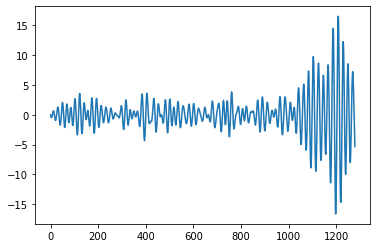

In [63]:
plt.plot(filtered_sigma[0*srate : 5 * srate])

## PSD of sigma envelopeµ

In [190]:
da_pxx_of_amplitudes = None
f_low = 12
f_high = 15
for patient in patients:
    da = xr.load_dataarray(f'../dataarray/da_tf_frontal_{patient}.nc')
    sigma_power = da.loc['raw',f_low:f_high,:].sum('freqs').values
    f, Pxx = gh.spectre(sigma_power, srate, wsize = 50)
    if da_pxx_of_amplitudes is None:
        da_pxx_of_amplitudes = gh.init_da({'participant':patients, 'freqs':f})
    da_pxx_of_amplitudes.loc[patient, :] = Pxx

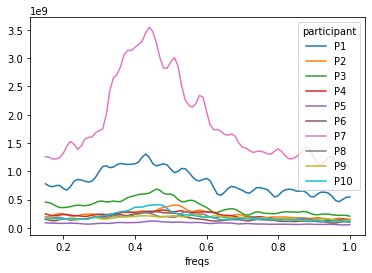

In [191]:
da_pxx_of_amplitudes.loc[:,0.15:1].plot.line(x='freqs',hue = 'participant')

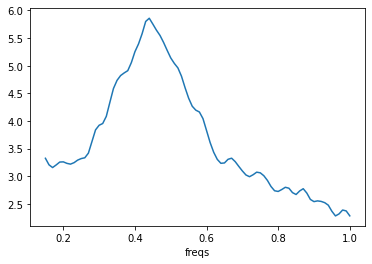

In [184]:
da_pxx_of_amplitudes.loc[:,0.15:1].mean('participant').plot()

In [174]:
for participant in patients:
    print(da_pxx_of_amplitudes.loc[participant,0.15:1].idxmax().values)

0.42500000000000004
0.5125000000000001
0.4625
0.47500000000000003
0.45
0.42500000000000004
0.4375
0.42500000000000004
0.5625
0.4625


In [5]:
da_pxx_all = xr.load_dataarray('../dataarray/da_pxx_all.nc')

NameError: name 'da_pxx_of_amplitudes' is not defined

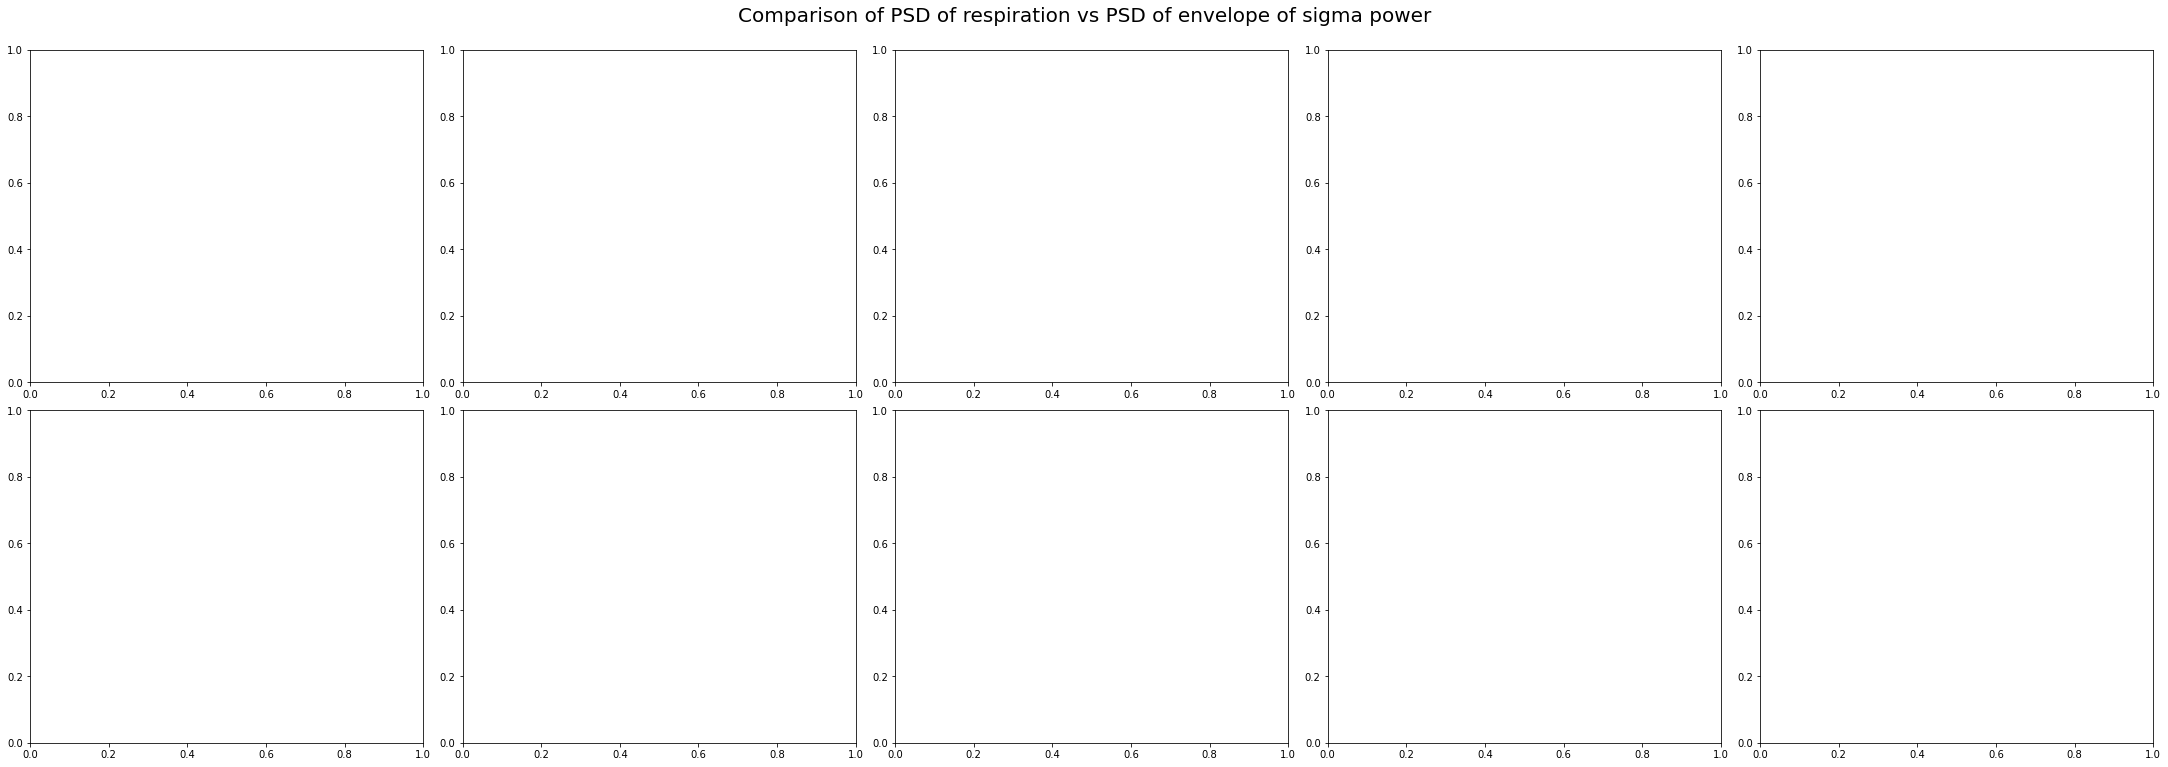

In [4]:
fig , axs = plt.subplots(nrows = 2, ncols = 5, figsize = (30,10), constrained_layout = True)
fig.suptitle('Comparison of PSD of respiration vs PSD of envelope of sigma power', fontsize = 20, y = 1.05)
for row, sublist in enumerate([patients[:5] , patients[5:]]):
    for col, participant in enumerate(sublist):
        ax = axs[row, col]
        f = da_pxx_all.coords['freq'].loc[0:1].values
        psd_rsp = da_pxx_all.loc[participant,'N2','DEBIT','raw',0:1].values
        psd_sigma_power_envelope = da_pxx_of_amplitudes.loc[participant,0:1].values
        ax.plot(f, psd_rsp, label = 'PSD of Respiration')
        ax2 = ax.twinx()
        ax2.plot(f, psd_sigma_power_envelope, label = 'PSD of Sigma Envelope', color = 'darkorange')
        ax.set_title(participant)
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('PSD of Respi [AU]')
        ax2.set_ylabel('PSD of Sigma Envelope [AU]')
        ax.legend(loc=2)
        ax2.legend(loc = 1)
# plt.savefig('../presentation_4/psd_sigma_env_respi', bbox_inches = 'tight')
plt.show()    

In [295]:
high_modulation = gh.simu_pac_sig(100, 0.5, 10, 15, 1 , 50, 120, srate)
low_modulation = gh.simu_pac_sig(0.05, 0.5, 10, 15, 1 , 50, 120, srate)

In [296]:
high_mi = gh.raw_to_mi(sig=high_modulation, modulant_freqs = (0.1,1.5), target_freqs = (10,20), srate=srate)
low_mi = gh.raw_to_mi(sig=low_modulation, modulant_freqs = (0.1,1.5), target_freqs = (10,20), srate=srate)

In [297]:
high_mi

0.03828779670228213

In [298]:
low_mi

0.0011439716391192355

In [299]:
def raw_to_mi(sig, modulant_freqs, target_freqs, srate, N=18):
    sig = sig - np.mean(sig)
    phase_modulant, amp_target = gh.get_phase_amplitude_vectors(sig=sig, modulant_freqs=modulant_freqs, target_freqs=target_freqs, srate=srate)
    pac_distribution = gh.get_amplitude_distribution(phase_modulant, amp_target, N)
    mi = gh.Modulation_Index(pac_distribution, show = True)
    return mi

0.0011439716391192355

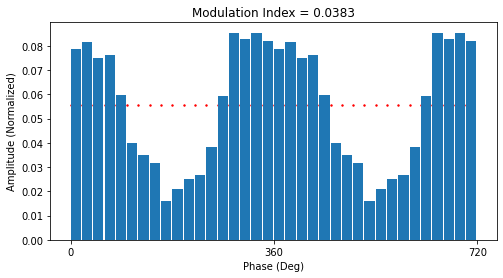

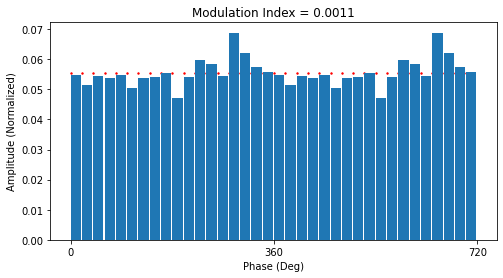

In [302]:
raw_to_mi(sig=high_modulation, modulant_freqs = (0.1,1.5), target_freqs = (10,20), srate=srate)
raw_to_mi(sig=low_modulation, modulant_freqs = (0.1,1.5), target_freqs = (10,20), srate=srate)

0.0011439716391192355

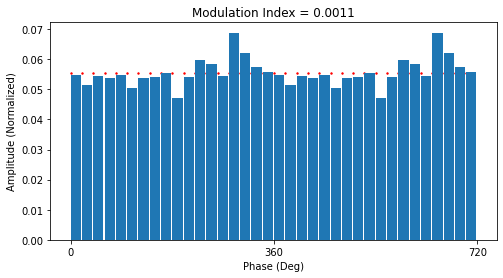

In [3]:
da = xr.load_dataarray(f'../dataarray/da_tf_frontal_{patient}.nc')

In [4]:
da

<xarray.DataArray (normalisation: 2, freqs: 40, time: 871680)>
array([[[3.2953965e+04, 3.2815191e+04, 3.2509861e+04, ...,
         5.3648828e+04, 5.4629113e+04, 5.5356980e+04],
        [2.9152561e+04, 2.8929809e+04, 2.8557326e+04, ...,
         5.4764211e+04, 5.5488555e+04, 5.5971691e+04],
        [2.6226281e+04, 2.5961822e+04, 2.5562268e+04, ...,
         5.5459746e+04, 5.5983707e+04, 5.6274520e+04],
        ...,
        [8.7672842e+03, 8.7404541e+03, 8.6708662e+03, ...,
         1.7843797e+04, 1.8110104e+04, 1.8292654e+04],
        [8.7663408e+03, 8.7561895e+03, 8.7044102e+03, ...,
         1.7086312e+04, 1.7380447e+04, 1.7590865e+04],
        [8.7677832e+03, 8.7713760e+03, 8.7340264e+03, ...,
         1.6491691e+04, 1.6803094e+04, 1.7030938e+04]],

       [[2.1924427e+00, 2.1816783e+00, 2.1579945e+00, ...,
         3.7977061e+00, 3.8737450e+00, 3.9302044e+00],
        [1.8975747e+00, 1.8802960e+00, 1.8514034e+00, ...,
         3.8842244e+00, 3.9404104e+00, 3.9778864e+00],
        [1.6705883e+00, 1.6500748e+00, 1.6190821e+00, ...,
         3.9381757e+00, 3.9788184e+00, 4.0013762e+00],
        ...,
        [3.1632528e-01, 3.1424409e-01, 3.0884629e-01, ...,
         1.0203741e+00, 1.0410310e+00, 1.0551912e+00],
        [3.1625208e-01, 3.1546468e-01, 3.1144825e-01, ...,
         9.6161735e-01, 9.8443288e-01, 1.0007546e+00],
        [3.1636396e-01, 3.1664267e-01, 3.1374553e-01, ...,
         9.1549367e-01, 9.3964863e-01, 9.5732206e-01]]], dtype=float32)
Coordinates:
  * freqs          (freqs) float64 10.0 10.26 10.51 10.77 ... 19.49 19.74 20.0
  * time           (time) float64 0.0 0.007812 0.01562 ... 6.81e+03 6.81e+03
  * normalisation  (normalisation) object 'raw' 'normal'

In [13]:
da_pxx_env = None
for patient in patients:
    da = xr.load_dataarray(f'../dataarray/da_staged_{patient}.nc')
    sigma_filtered = gh.filter_sig(da.loc['N2',['Fp2-C4','Fp1-C3'],:].mean('chan').values, low = 11 , high = 15, fs=srate )
    sigma_env = gh.get_amp(sigma_filtered)
    respi = da.loc['N2','DEBIT',:].values
    f, Pxx = gh.spectre(sigma_env, srate=srate, wsize = 50)
    f, Cxy = gh.coherence(sigma_env, respi,  srate=srate, wsize = 50)
    if da_pxx_env is None:
        da_pxx_env = gh.init_da({'participant':patients, 'mode':['pxx','cxy'], 'freq':f})
    da_pxx_env.loc[patient, 'pxx', :] = Pxx  
    da_pxx_env.loc[patient, 'cxy', :] = Cxy  

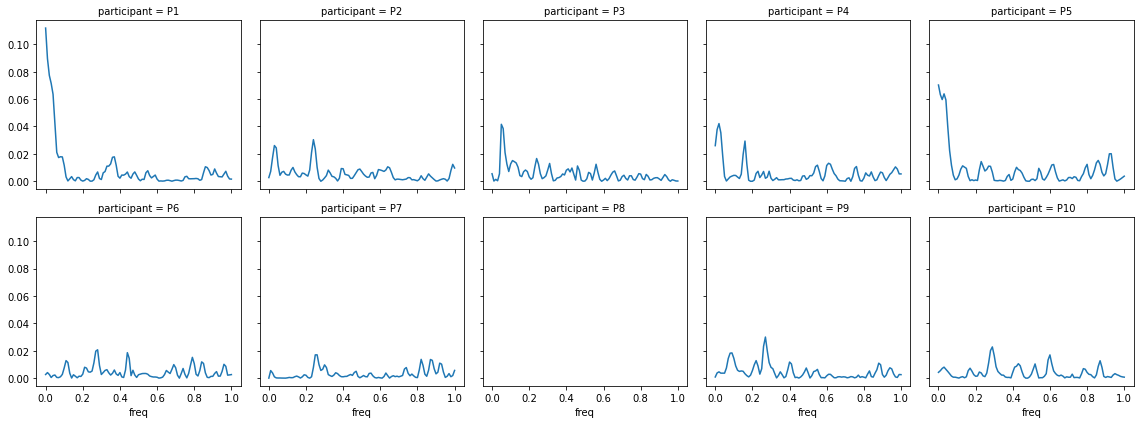

In [14]:
da_pxx_env.loc[:,'cxy',0:1].plot.line(x='freq',col = 'participant', col_wrap = 5)

In [26]:
da_pxx_all = xr.load_dataarray('../dataarray/da_pxx_all.nc')

In [10]:
def reduce(sig):
    return sig / np.std(sig)

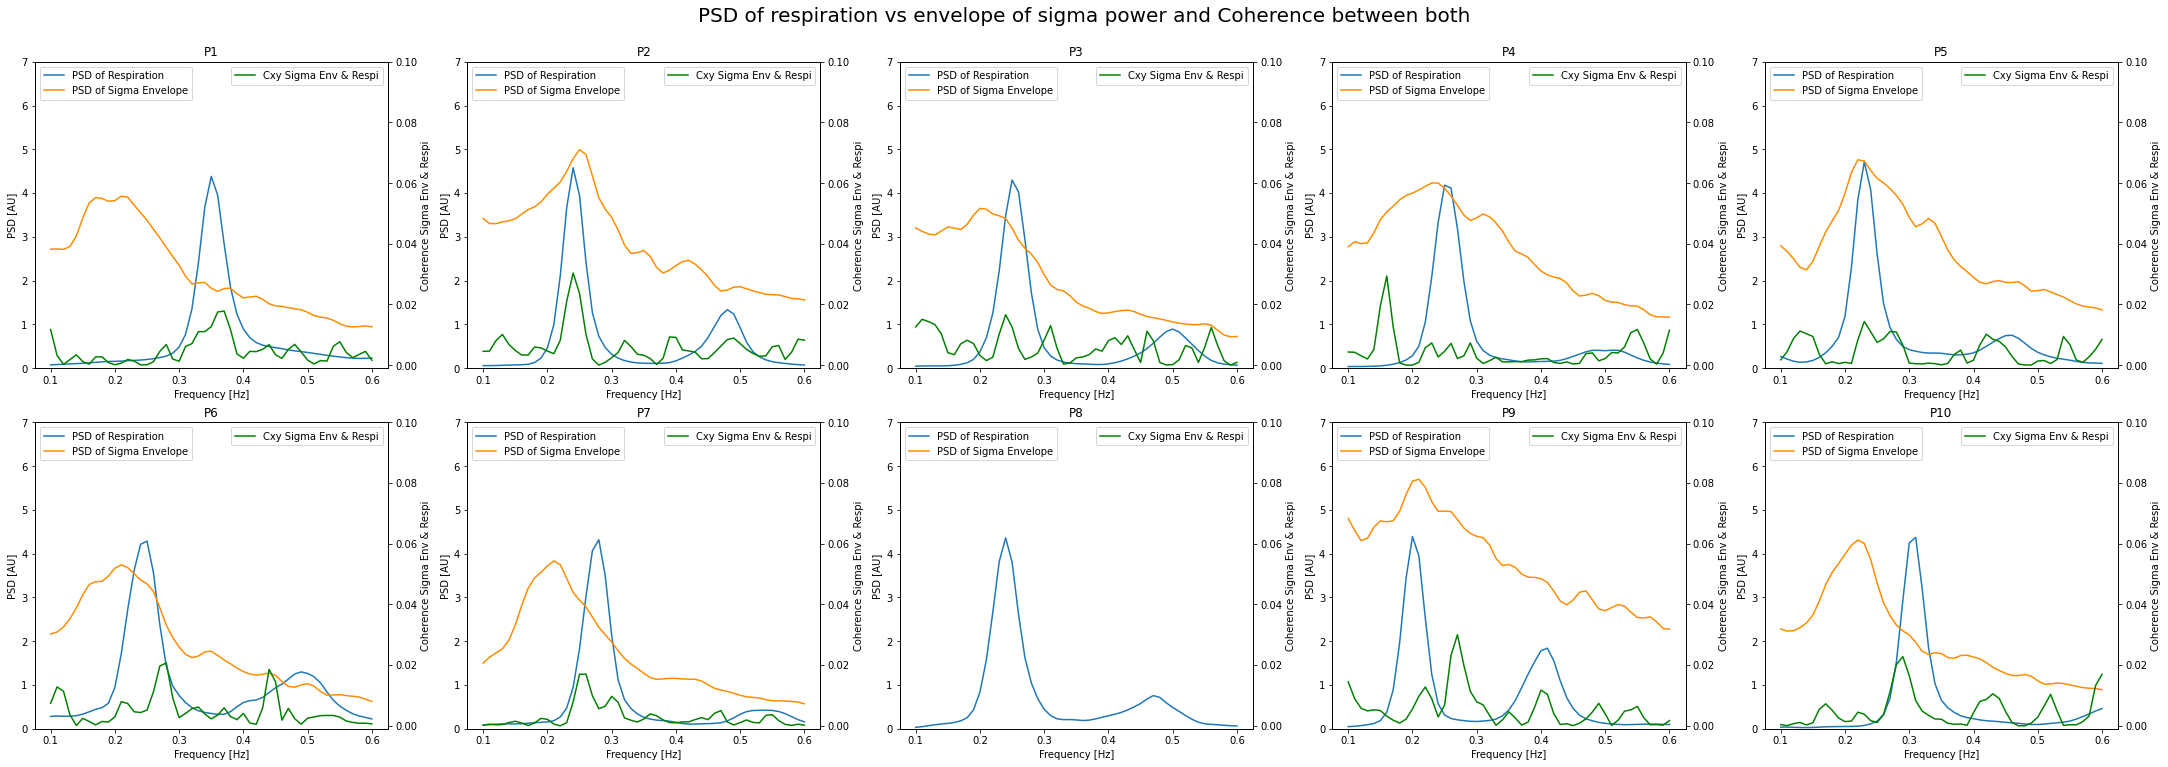

In [16]:
fig , axs = plt.subplots(nrows = 2, ncols = 5, figsize = (30,10), constrained_layout = True)
fig.suptitle('PSD of respiration vs envelope of sigma power and Coherence between both', fontsize = 20, y = 1.05)
lf = 0.1
hf = 0.6
for row, sublist in enumerate([patients[:5] , patients[5:]]):
    for col, participant in enumerate(sublist):
        ax = axs[row, col]
        f = da_pxx_all.coords['freq'].loc[lf:hf].values
        psd_rsp = reduce(da_pxx_all.loc[participant,'N2','DEBIT','raw',lf:hf].values)
        psd_sigma_power_envelope = reduce(da_pxx_env.loc[participant,'pxx',lf:hf].values)
        cxx_sigma_resp = da_pxx_env.loc[participant,'cxy',lf:hf].values
        ax.plot(f, psd_rsp, label = 'PSD of Respiration')
        ax.plot(f, psd_sigma_power_envelope, label = 'PSD of Sigma Envelope', color = 'darkorange')
        ax2 = ax.twinx()
        ax2.plot(f, cxx_sigma_resp, label = 'Cxy Sigma Env & Respi', color = 'g')
        ax2.set_ylabel('Coherence Sigma Env & Respi')
        ax2.set_ylim(-0.001,0.1)
        ax.set_ylim(-0.001, 7)
        ax2.legend(loc = 1)
        ax.set_title(participant)
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('PSD [AU]')
        ax.legend(loc = 2)
# plt.savefig('../presentation_4/psd_sigma_env_respi_cxy', bbox_inches = 'tight')
plt.show()    